In [1]:
#Imports for analysing data
import numpy as np 
import pandas as pd 
import os
import glob


#imports for displaying images
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import PIL
from ipywidgets import interactive, interact, ToggleButtons,IntSlider

#imports for building the model
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator



In [2]:
train_data = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
train_data


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


In [3]:
final_train = train_data
final_train['ext'] = train_data['id']+'.png'

final_train = pd.DataFrame(final_train)
final_train

,id,class,segmentation,ext
0,case123_day20_slice_0001,large_bowel,NaN,case123_day20_slice_0001.png
1,case123_day20_slice_0001,small_bowel,NaN,case123_day20_slice_0001.png
2,case123_day20_slice_0001,stomach,NaN,case123_day20_slice_0001.png
3,case123_day20_slice_0002,large_bowel,NaN,case123_day20_slice_0002.png
4,case123_day20_slice_0002,small_bowel,NaN,case123_day20_slice_0002.png
...,...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN,case30_day0_slice_0143.png
115484,case30_day0_slice_0143,stomach,NaN,case30_day0_slice_0143.png
115485,case30_day0_slice_0144,large_bowel,NaN,case30_day0_slice_0144.png
115486,case30_day0_slice_0144,small_bowel,NaN,case30_day0_slice_0144.png


In [4]:
#Creating dataframe with large bowel segmentation values and corresponding id

lb_df = train_data[(train_data['class']=='large_bowel')]
lb_df = pd.DataFrame(lb_df)
lb_df.rename(columns={'segmentation': 'lb_seg'}, inplace =True)
lb_df = lb_df[['id','lb_seg']]


#Creating dataframe with small bowel segmentation values and corresponding id

sb_df = train_data[(train_data['class']=='small_bowel')]
sb_df = pd.DataFrame(sb_df)
sb_df.rename(columns={'segmentation': 'sb_seg'}, inplace =True)
sb_df = sb_df[['id','sb_seg']]

#Creating dataframe with stomach segmentation values and corresponding id

stm_df = train_data[(train_data['class']=='stomach')]
stm_df = pd.DataFrame(stm_df)
stm_df.rename(columns={'segmentation': 'stm_seg'}, inplace =True)
stm_df = stm_df[['id','stm_seg']]

In [5]:
#Merging the 3 created dataframes

new_train_df = lb_df
pd.DataFrame(new_train_df)
new_train_df = new_train_df.merge(sb_df, on='id')
new_train_df = new_train_df.merge(stm_df, on='id')
new_train_df


,id,lb_seg,sb_seg,stm_seg
0,case123_day20_slice_0001,NaN,NaN,NaN
1,case123_day20_slice_0002,NaN,NaN,NaN
2,case123_day20_slice_0003,NaN,NaN,NaN
3,case123_day20_slice_0004,NaN,NaN,NaN
4,case123_day20_slice_0005,NaN,NaN,NaN
...,...,...,...,...
38491,case30_day0_slice_0140,NaN,NaN,NaN
38492,case30_day0_slice_0141,NaN,NaN,NaN
38493,case30_day0_slice_0142,NaN,NaN,NaN
38494,case30_day0_slice_0143,NaN,NaN,NaN


In [6]:
train_paths = glob.glob("../input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*")

temp_df = train_paths
temp_df = pd.DataFrame(temp_df,columns=['Path'])
temp_df['Path'][0]


'../input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png'

In [7]:
id_dict ={'id': temp_df['Path'].apply(lambda x: (x.split('/')[-3]) +'_slice_'+ (x.split('_')[-5])),
          'Ht': temp_df['Path'].apply(lambda x: x.split('_')[-4]),'Wt': temp_df['Path'].apply(lambda x: x.split('_')[-3]),
         'case': temp_df['Path'].apply(lambda x: x.split('/')[-4].replace('case','')),
         'day': temp_df['Path'].apply(lambda x: (x.split('_')[-6]).split('/')[-3].replace('day','')),
         'slice': temp_df['Path'].apply(lambda x: x.split('_')[-5]) }
temp_df['id'] = id_dict['id']
temp_df['Ht'] = id_dict['Ht']
temp_df['Wt'] = id_dict['Wt']
temp_df['case'] = id_dict['case']
temp_df['day'] = id_dict['day']
temp_df['slice'] = id_dict['slice']
temp_df[['id','case','day','slice','Ht','Wt','Path']]
train_df = new_train_df.merge(temp_df, on='id')

In [8]:
train_df = pd.DataFrame(train_df)

#Removing unreliable image datas
drop_list=[]
for i in range(len(train_df)):
    if((train_df['case'][i]=='7' and train_df['day'][i]=='0') or (train_df['case'][i]=='81' and train_df['day'][i]=='30') ):
        drop_list.append(i)
train_df = train_df.drop(index= drop_list)
train_df = train_df.reset_index(drop=True)

train_df['lb_flag']= train_df["lb_seg"].apply(lambda x: not pd.isna(x))
train_df['sb_flag']= train_df["sb_seg"].apply(lambda x: not pd.isna(x))
train_df['stm_flag']= train_df["stm_seg"].apply(lambda x: not pd.isna(x))
train_df["n_segs"] = train_df["lb_flag"].astype(int)+train_df["sb_flag"].astype(int)+train_df["stm_flag"].astype(int)
train_df = train_df[['id','case','day','slice','n_segs','lb_seg','lb_flag','sb_seg','sb_flag','stm_seg','stm_flag','Ht','Wt','Path']]
train_df

,id,case,day,slice,n_segs,lb_seg,lb_flag,sb_seg,sb_flag,stm_seg,stm_flag,Ht,Wt,Path
0,case123_day20_slice_0001,123,20,0001,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0002,123,20,0002,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0003,123,20,0003,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0004,123,20,0004,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0005,123,20,0005,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38203,case30_day0_slice_0140,30,0,0140,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
38204,case30_day0_slice_0141,30,0,0141,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
38205,case30_day0_slice_0142,30,0,0142,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...
38206,case30_day0_slice_0143,30,0,0143,0,NaN,False,NaN,False,NaN,False,266,266,../input/uw-madison-gi-tract-image-segmentatio...


**Displaying Original Images**

In [9]:
def png_to_array(x):

    img = PIL.Image.open(x).resize((220,220), PIL.Image.ANTIALIAS)
    img_data = img.getdata()
    arr = np.array(img_data).reshape(220,220)
    arr = arr/255
    return arr

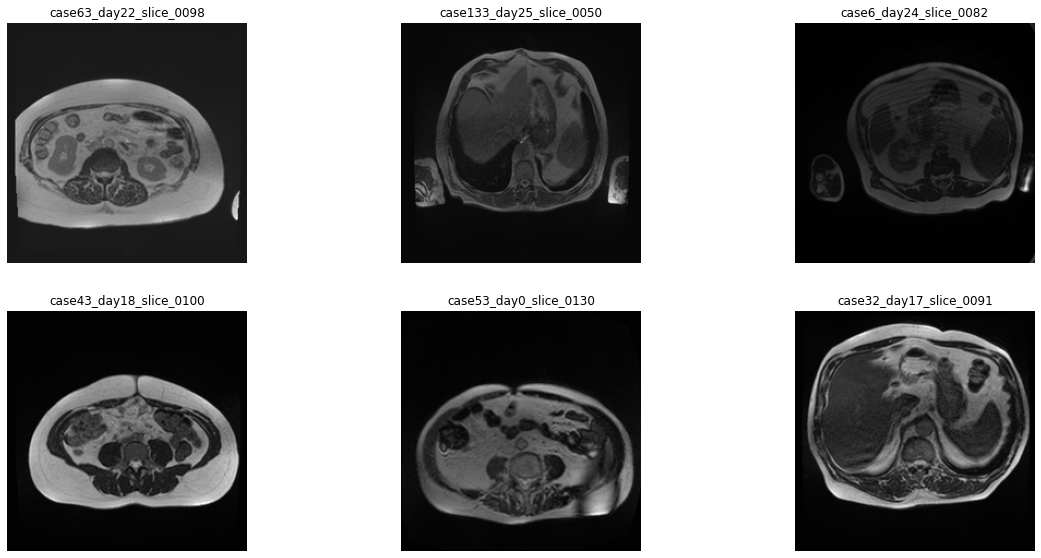

In [10]:
plt.figure(figsize=(20,15))    
for i in range(6):
    j =np.random.randint(1,len(train_df['Path']))
    plt.subplot(3,3,i+1)
    plt.axis('Off')
    plt.title(train_df['id'][j])
    plt.imshow(png_to_array(train_df['Path'][j]),cmap='gray')

In [11]:
def interactive_path(case_no='123',day_no='20'):
    display_paths=[]
    display_id=[]
    for i in range(len(train_df['id'])):
        if (train_df['case'][i]==case_no and train_df['day'][i]==day_no):
            display_paths.append(png_to_array(train_df['Path'][i]))
            display_id.append(train_df['id'][i])
    
    display_arr=np.asarray(display_paths)
    
    def explore_3dimage(layer):
        plt.figure(figsize=(10, 5))
        plt.imshow(display_arr[layer,:, :], cmap='gray');
        plt.title(display_id[layer])
        plt.axis('off')
        return layer

    interact(explore_3dimage,layer=(0,display_arr.shape[0]-1))

In [12]:
#case = input("Enter case number")
#day = input("Enter day")
interactive_path()

interactive(children=(IntSlider(value=71, description='layer', max=143), Output()), _dom_classes=('widget-inte…

**Displaying Image With Mask**

In [13]:
def mask_maker(seg, ht, wt):
    #seg --> segment coordinates 
    #ht --> height of corresponding image
    #wt --> width of corresponding image
    
    seg_arr = np.asarray(seg.split(), dtype='int')
    start_point = seg_arr[0::2] -1
    length_point = seg_arr[1::2]

    end_point = start_point + length_point

    case_mask = np.zeros(int(ht)*int(wt), dtype=np.uint8)

    for start, end in zip(start_point, end_point):
            case_mask[start:end] = 1

    case_mask = case_mask.reshape(int(wt), int(ht))
    case_mask = case_mask
    return case_mask
        

In [14]:
def img_reader(file, ht, wt):
    
    #Reads the original image and reshapes it accordingly to fit the mask
    
    c_img = PIL.Image.open(file)
    c_img_data = c_img.getdata()
    
    if (ht==wt):
        c_arr = np.array(c_img_data).reshape(int(ht), int(wt))
    else:
         c_arr = np.array(c_img_data).reshape(int(wt), int(ht))
  
    return c_arr

In [15]:
#Dataframe containing id's that have all 3 segmentations available

all_img_df = train_df[['id','case','day','lb_seg','sb_seg','stm_seg','Ht','Wt','Path']]
all_img_df = pd.DataFrame(all_img_df.dropna()).reset_index(drop=True)
all_img_df

,id,case,day,lb_seg,sb_seg,stm_seg,Ht,Wt,Path
0,case123_day20_slice_0082,123,20,17481 4 17746 7 18010 10 18275 12 18539 14 188...,22236 2 22500 6 22765 8 23030 10 23296 10 2356...,11052 8 11314 15 11578 19 11843 23 12108 26 12...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0083,123,20,17480 6 17745 8 18010 11 18275 13 18540 15 188...,22234 6 22499 9 22764 10 23030 11 23296 11 235...,11049 11 11313 16 11577 20 11842 23 12107 26 1...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0084,123,20,17215 4 17479 8 17745 9 18010 12 18275 14 1854...,21436 4 21701 7 21966 9 22231 11 22497 12 2276...,11045 14 11308 19 11572 23 11838 24 12103 27 1...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0085,123,20,16950 2 17214 7 17479 10 17491 4 17744 19 1800...,21435 7 21699 10 21965 11 22230 13 22496 14 22...,11043 16 11307 20 11572 23 11837 25 12102 27 1...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0086,123,20,16949 2 17213 8 17225 4 17478 19 17743 21 1800...,21166 6 21431 8 21660 8 21696 11 21925 10 2196...,11046 11 11307 19 11571 23 11836 25 12101 27 1...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
...,...,...,...,...,...,...,...,...,...
3169,case30_day0_slice_0123,30,0,17448 7 17464 6 17710 30 17974 34 18240 35 185...,22284 7 22548 11 22814 12 23079 14 23344 16 23...,17416 10 17680 16 17941 22 18204 26 18466 31 1...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
3170,case30_day0_slice_0124,30,0,17444 11 17708 19 17733 4 17973 33 18232 42 18...,22283 5 22548 10 22813 12 23078 14 23344 15 23...,17683 8 17944 14 18204 20 18467 24 18729 28 18...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
3171,case30_day0_slice_0125,30,0,17443 11 17708 16 17959 39 18219 52 18483 57 1...,22282 5 22547 9 22812 12 23078 13 23343 16 236...,18206 2 18469 8 18731 13 18993 19 19256 23 195...,266,266,../input/uw-madison-gi-tract-image-segmentatio...
3172,case30_day0_slice_0126,30,0,17443 11 17700 23 17957 39 18219 47 18466 70 1...,22281 7 22546 9 22811 12 23077 13 23342 16 236...,20855 4 21120 6 21385 8 21650 10 21916 10 2218...,266,266,../input/uw-madison-gi-tract-image-segmentatio...


In [16]:
def mask_trimer(seg,file,ht,wt,n):
    mask = mask_maker(seg[n],ht[n],wt[n])
    mask_color = mask.astype(np.float64)
    mask_color[np.where(mask_color==0)]=np.nan
    img = img_reader(file[n],ht[n],wt[n])
    return mask_color,img


In [17]:
#Visualising each organ's mask individually

def visualiser_1():
    fig = plt.figure()
    plt.figure(figsize=(20,15)) 
    
    a = 1
    for i in range(3):
        k = np.random.randint(0,len(all_img_df['id']))
        print('Row',i+1,'ID=', all_img_df['id'][k],'\n\n')
          
        
        for j in range(3):
            plt.subplot(3,3,a)
            plt.axis('Off') 
            
            
            if (j==0):#Large bowel
                mask_color,img = mask_trimer(all_img_df['lb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],k)
                a+=1
                plt.title("Large Bowel")
                plt.imshow(mask_color, interpolation='nearest',cmap='viridis',vmin=0,vmax=1)
                plt.imshow(img,cmap='gray', alpha =0.7)    
            
            elif (j==1):#Small bowel
                mask_color,img = mask_trimer(all_img_df['sb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],k)
                a+=1
                plt.title("Small Bowel")
                plt.imshow(mask_color, interpolation='nearest', cmap ='rainbow', vmin=0,vmax=1)
                plt.imshow(img,cmap='gray', alpha =0.8)
            
            elif(j==2):#Stomach
                mask_color,img = mask_trimer(all_img_df['stm_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],k)
                a+=1
                plt.title("Stomach")
                plt.imshow(mask_color, interpolation='nearest', cmap ='rainbow_r',vmin=0,vmax=1)
                plt.imshow(img,cmap='gray', alpha =0.8)
       

        

   
    

Each row represents 'one' case ID


Row 1 ID= case121_day14_slice_0085 


Row 2 ID= case66_day36_slice_0087 


Row 3 ID= case145_day19_slice_0085 




<Figure size 432x288 with 0 Axes>

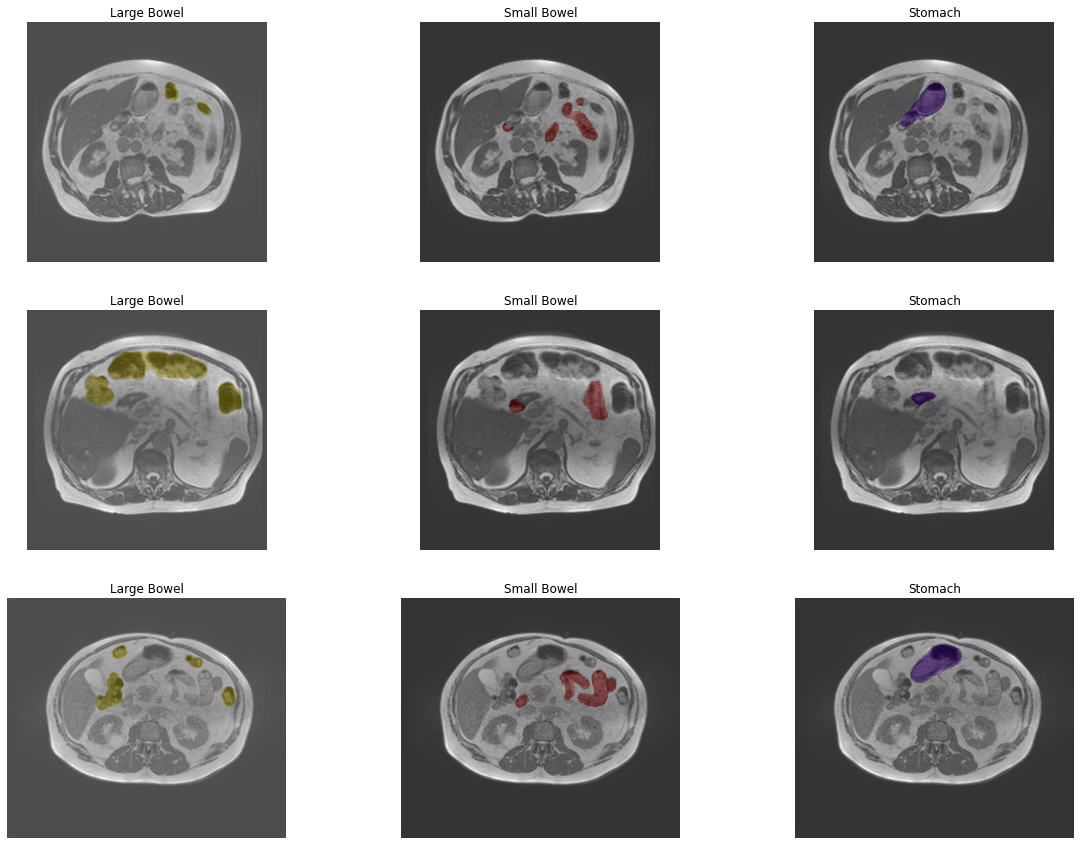

In [18]:
print("Each row represents 'one' case ID\n\n")
visualiser_1()

In [19]:

def visualiser_2():
    fig = plt.figure()
    plt.figure(figsize=(20,15)) 
    a = 1
    
    labels = ['lb','sb','stm']
    for i in range(3):
        k = np.random.randint(0,len(all_img_df['id']))   
        orig_img = img_reader(all_img_df['Path'][k],all_img_df['Ht'][k],all_img_df['Wt'][k])
        plt.subplot(1,3,i+1)
        plt.imshow(orig_img,cmap='gray', alpha =1) 
        
        for j in range(3):
            plt.subplot(1,3,a)
            plt.axis('Off') 
            
            if(j==0):#printing Large bowel seg mask
                mask_color,img = mask_trimer(all_img_df['lb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],k)
                plt.imshow(mask_color, interpolation='nearest',cmap='viridis',vmin=0,vmax=1)
                plt.title(all_img_df['id'][k])
               
                
            elif(j==1):#printing Small bowel seg mask
                mask_color,img = mask_trimer(all_img_df['sb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],k)
                plt.imshow(mask_color, interpolation='nearest', cmap = 'rainbow', vmin=0,vmax=1)
                
            elif(j==2):#printing Stomach seg mask
                mask_color,img = mask_trimer(all_img_df['stm_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],k)
                red_patch = mpatches.Patch(color='red', label='small bowel')
                yel_patch = mpatches.Patch(color='yellow', label='large bowel')
                pur_patch = mpatches.Patch(color='purple', label='stomach')
                plt.legend(handles=[yel_patch,red_patch,pur_patch])
                plt.imshow(mask_color, interpolation='nearest', cmap = 'rainbow_r',vmin=0,vmax=1)
               
        a+=1


<Figure size 432x288 with 0 Axes>

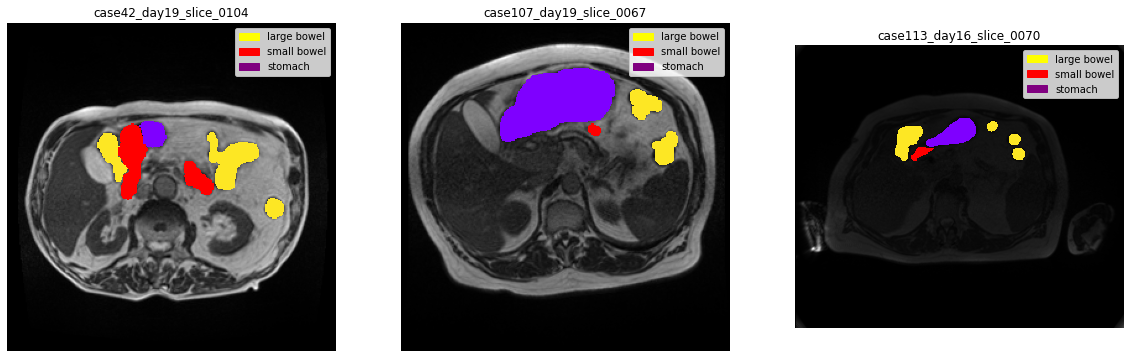

In [20]:
visualiser_2()

**Region-wise segmentation interactive view**

In [21]:
def days(case_no):
    day_list =[]
    for i in range(len(all_img_df['id'])):
        if(all_img_df['case'][i]== case_no):
            day_list.append(all_img_df['day'][i])
    k = np.random.randint(0,len(day_list))
    return day_list[k]

In [22]:
case_list = list(all_img_df['case'].unique())

def interactive_path(region):
    k = np.random.randint(0,len(case_list))
    case = case_list[k]
    day = days(case)
    
    if(region=='All'):
        
        mask_lb=[]
        mask_sb=[]
        mask_stm=[]
        img_l=[]
        id_l=[]
        for i in range(len(all_img_df['id'])):
            if (all_img_df['case'][i]==case and all_img_df['day'][i]==day):
                mask_color_lb,img = mask_trimer(all_img_df['lb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],i)
                mask_lb.append(mask_color_lb)
                img_l.append(img)
                
                mask_color_sb,img = mask_trimer(all_img_df['sb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],i)
                mask_sb.append(mask_color_sb)
                
                  
                mask_color_stm,img = mask_trimer(all_img_df['stm_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],i)
                mask_stm.append(mask_color_stm)
                id_l.append(all_img_df['id'][i])
                
        img_arr = np.asarray(img_l)
        mask_lb_arr = np.asarray(mask_lb)
        mask_sb_arr = np.asarray(mask_sb)
        mask_stm_arr = np.asarray(mask_stm)
        
    elif(region=='Large Bowel') :
      
        mask_l=[]
        img_l=[]
        id_l=[]
        for i in range(len(all_img_df['id'])):
            if (all_img_df['case'][i]==case and all_img_df['day'][i]==day):
                mask_color,img = mask_trimer(all_img_df['lb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],i)
                mask_l.append(mask_color)
                img_l.append(img)
                id_l.append(all_img_df['id'][i])
        
        mask_arr = np.asarray(mask_l)
        img_arr = np.asarray(img_l)
        color = 'viridis'
        
    elif(region=='Small Bowel') :
       
        mask_l=[]
        img_l=[]
        id_l=[]
        for i in range(len(all_img_df['id'])):
            if (all_img_df['case'][i]==case and all_img_df['day'][i]==day):
                mask_color,img = mask_trimer(all_img_df['sb_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],i)
                mask_l.append(mask_color)
                img_l.append(img)
                id_l.append(all_img_df['id'][i])
        
        mask_arr = np.asarray(mask_l)
        img_arr = np.asarray(img_l)
        color = 'rainbow'

    elif(region=='Stomach') :
       
        mask_l=[]
        img_l=[]
        id_l=[]
        for i in range(len(all_img_df['id'])):
            if (all_img_df['case'][i]==case and all_img_df['day'][i]==day):
                mask_color,img = mask_trimer(all_img_df['stm_seg'],all_img_df['Path'],all_img_df['Ht'],all_img_df['Wt'],i)
                mask_l.append(mask_color)
                img_l.append(img)
                id_l.append(all_img_df['id'][i])
        
        mask_arr = np.asarray(mask_l)
        img_arr = np.asarray(img_l)
        color = 'rainbow_r'

        
        
    def interactive_plot(slices):
        for j in range((img_arr.shape[0])):
            
            if (region=='All'):
                plt.subplot(1,1,1) 
                plt.imshow(img_arr[slices,:,:], cmap='gray', alpha=1)
                plt.imshow(mask_lb_arr[slices,:,:], interpolation='nearest',cmap='viridis',vmin=0,vmax=1)
                plt.imshow(mask_sb_arr[slices,:,:], interpolation='nearest',cmap='rainbow',vmin=0,vmax=1)
                plt.imshow(mask_stm_arr[slices,:,:], interpolation='nearest',cmap='rainbow_r',vmin=0,vmax=1)
                plt.title(id_l[slices]) 
                
            else:
                plt.subplot(1,1,1) 
                plt.imshow(img_arr[slices,:,:], cmap='gray', alpha=1)
                plt.imshow(mask_arr[slices,:,:], interpolation='nearest',cmap=color,vmin=0,vmax=1)
                plt.title(id_l[slices]) 
                
        y_patch = mpatches.Patch(color='yellow',label = 'Large Bowel')
        r_patch = mpatches.Patch(color='red', label = 'Small Bowel')
        p_patch = mpatches.Patch(color='purple', label = 'Stomach')
        plt.legend(handles=[y_patch,r_patch,p_patch], bbox_to_anchor=(1.6, 1.05))
        
    interact(interactive_plot,slices = (0,img_arr.shape[0]-1))

In [23]:
select_region = ToggleButtons(
    options = ['All','Large Bowel','Small Bowel','Stomach'],
    description = "Pick region:",
    button_style = 'info',
)
interactive(interactive_path,region=select_region)

interactive(children=(ToggleButtons(button_style='info', description='Pick region:', options=('All', 'Large Bo…